In [1]:
import torch
import sys
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler, AutoConfig
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
from pathlib import Path
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Importing the custom preprocessor
sys.path.append(str(Path.cwd().parents[1] / "src"))
from preprocessing.preprocess_dataset import DistilBertPreprocessor

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# CONFIGURATION
MODEL_NAME = 'distilbert-base-uncased'
sys.path.append(str(Path.cwd().parents[2]))
DATA_DIR = Path("/Volumes/MACBACKUP/final_datasets/")
SAVE_PATH = Path("/models/distilber-v2")
CHECKPOINT_PATH = Path("./models/distilber-v2")
LEARNING_RATE = 3e-5
EPOCHS = 20
BATCH_SIZE = 8
EARLY_STOPPING_PATIENCE = 3

In [3]:
# DATA PREPARATION
#  PYTORCH DATASET CLASS
class DepressionDataset(Dataset):
    """Custom Dataset class for our depression text data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # The encodings are already tensors from the tokenizer
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device, loss_fn):
    """
    Evaluates the model on a given dataset.
    NOW ACCEPTS a weighted loss_fn to calculate validation loss.
    """
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get model outputs (logits)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # --- CHANGED ---
            # Calculate loss manually using the provided weighted loss function
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    # Use 'weighted' f1-score for a better view of imbalanced data
    f1 = f1_score(all_labels, all_preds, average='weighted') 
    
    return avg_loss, accuracy, f1

In [5]:
def plot_metrics(history, save_dir):
    """Generates and saves plots for training metrics."""
    output_dir = Path(save_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    epochs = range(1, len(history['train_loss']) + 1)

    # Plots for Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir / 'training_validation_loss.png')
    print(f"Saved training and validation loss plot to {output_dir}")

    # Plots for Accuracy and F1-Score
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_accuracy'], 'c-o', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'g-o', label='Validation Accuracy')
    plt.plot(epochs, history['val_f1'], 'm-o', label='Validation F1-Score')
    plt.title('Training/Validation Accuracy & F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir / 'metrics.png')
    print(f"Saved metrics plot to {output_dir}")

In [6]:
# Device Setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (GPU) for training.")
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU for training.")

# Data Loading and Preprocessing
preprocessor = DistilBertPreprocessor()

# Loading raw data
print("Loading and preprocessing data...")
X_train_df, y_train_df = preprocessor.load_and_preprocess(DATA_DIR / "final_train_dataset.csv")
X_dev_df, y_dev_df = preprocessor.load_and_preprocess(DATA_DIR / "final_dev_dataset.csv")

# Chunking the dataframes
X_train_chunked, y_train_chunked = preprocessor.chunk_dataframe(X_train_df, y_train_df, strategy="sentence_aware", chunk_size=510, overlap=2)
X_dev_chunked, y_dev_chunked = preprocessor.chunk_dataframe(X_dev_df, y_dev_df, strategy="sentence_aware", chunk_size=510, overlap=2)

# Tokenizing the final chunked text
train_encodings = preprocessor.tokenize(X_train_chunked['text'])
dev_encodings = preprocessor.tokenize(X_dev_chunked['text'])

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Using MPS (GPU) for training.
Loading and preprocessing data...


Token indices sequence length is longer than the specified maximum sequence length for this model (2218 > 512). Running this sequence through the model will result in indexing errors


Successfully loaded /Volumes/MACBACKUP/final_datasets/final_train_dataset.csv. Found 107 records.
Text cleaning complete.
Data prepared. X shape: (107, 1), y shape: (107, 1)

Successfully loaded /Volumes/MACBACKUP/final_datasets/final_dev_dataset.csv. Found 35 records.
Text cleaning complete.
Data prepared. X shape: (35, 1), y shape: (35, 1)

Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 107, Total chunks: 407
Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 35, Total chunks: 147
Tokenizing for DistilBERT with max_length=512...
Tokenizing for DistilBERT with max_length=512...


In [7]:
# We are using the 'preprocessor' object which contains the tokenizer
tokenizer = preprocessor.tokenizer

# Choose a chunk to inspect (e.g., the first chunk: index 0)
chunk_index = 50

# Getting the original text for this chunk
original_text_chunk = X_train_chunked['text'].iloc[chunk_index]

# Get the tokenized outputs for this chunk
input_ids_tensor = train_encodings['input_ids'][chunk_index]
attention_mask_tensor = train_encodings['attention_mask'][chunk_index]

# Convert the tensor of token IDs back into a list of human-readable tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor)

# --- Print the results for verification ---
print(f"--- INSPECTING CHUNK #{chunk_index} ---")
print(f"\nORIGINAL TEXT CHUNK:\n'{original_text_chunk}'")
print("\n" + "="*50)
print(f"\nCONVERTED TOKENS (what the model sees):\n{tokens}")
print("\n" + "="*50)
print(f"\nINPUT IDS (numerical representation of tokens):\n{input_ids_tensor.numpy()}")
print("\n" + "="*50)
print(f"\nATTENTION MASK (1s are real tokens, 0s are padding):\n{attention_mask_tensor.numpy()}")
print("\n" + "="*50)
print(f"Total Token Length: {len(tokens)}")

--- INSPECTING CHUNK #50 ---

ORIGINAL TEXT CHUNK:
't know i just don't get there i think that i'm a little bit afraid of losing my temper so i keep it under control laughter it was yesterday actually i argued with my boyfriend um about uh getting getting a job i was talking about taking a job somewhere and he was being very supportive and i really wanted him to to say no don't go take that job for six months'cause i would miss you and he was just being supportive so um we kind of argued about that laughter and it was ridiculous so we i ended up laughing and that was the end of the fight um meditate excercise go out in nature just um unplug get myself away from the computer away from technology away from people i would say not really um i'm an only child and it's just me and my parents and we're very very dissimilar for example um i'm a pretty adventurous person and i like learning and my parents are uh couch potatoes they like to watch reality television so we don't have too much to t

In [11]:


train_labels = y_train_chunked['label'].tolist()

label_counts = y_train_chunked['label'].value_counts().sort_index()

# Get counts for each class [0, 1]
class_sample_count = torch.tensor(label_counts.values, dtype=torch.float)

# Calculate weight: 1.0 / count
weight = 1. / class_sample_count.float()

# Assign the correct weight to each sample in the dataset
samples_weight = torch.tensor([weight[t] for t in train_labels])

sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)
    


In [12]:
# Creating PyTorch Datasets
train_dataset = DepressionDataset(train_encodings, y_train_chunked['label'].tolist())
dev_dataset = DepressionDataset(dev_encodings, y_dev_chunked['label'].tolist())

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Using unweighted CrossEntropyLoss.")
loss_fn = nn.CrossEntropyLoss().to(device)

Using unweighted CrossEntropyLoss.


In [13]:
def build_distilbert_classifier(num_labels=2):
    """
    Builds and compiles the DistilBERT model.
    """
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        attention_dropout=0.3,
        dropout=0.2
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    return model, optimizer

In [14]:
print("Setting up model, optimizer, and scheduler...")
model, optimizer = build_distilbert_classifier(num_labels=2)
model.to(device)

Setting up model, optimizer, and scheduler...


/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
 

In [15]:
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [16]:
print("Starting training...")
start_time = time.time()
    
history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
best_val_accuracy = 0.0
patience_counter = 0

Starting training...



--- Epoch 1/20 ---


Training:   0%|          | 0/51 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating on development set...
Epoch 1 | Train Loss: 0.6989 | Train Acc: 0.4767 | Val Loss: 0.7039 | Val Acc: 0.4354 | Val F1: 0.3641
Validation accuracy improved from 0.0000 to 0.4354. Saving model...

--- Epoch 2/20 ---


Evaluating on development set...
Epoch 2 | Train Loss: 0.6235 | Train Acc: 0.6486 | Val Loss: 0.9522 | Val Acc: 0.4286 | Val F1: 0.3716
No improvement in validation accuracy for 1 epoch(s).

--- Epoch 3/20 ---


Evaluating on development set...
Epoch 3 | Train Loss: 0.5664 | Train Acc: 0.7346 | Val Loss: 0.8094 | Val Acc: 0.6599 | Val F1: 0.6041
Validation accuracy improved from 0.4354 to 0.6599. Saving model...

--- Epoch 4/20 ---


Evaluating on development set...
Epoch 4 | Train Loss: 0.5516 | Train Acc: 0.7125 | Val Loss: 0.7700 | Val Acc: 0.6054 | Val F1: 0.5909
No improvement in validation accuracy for 1 epoch(s).

--- Epoch 5/20 ---


Evaluating on development set...
Epoch 5 | Train Loss: 0.3274 | Train Acc: 0.8747 | Val Loss: 0.8310 | Val Acc: 0.5918 | Val F1: 0.5906
No improvement in validation accuracy for 2 epoch(s).

--- Epoch 6/20 ---


Evaluating on development set...
Epoch 6 | Train Loss: 0.2287 | Train Acc: 0.9189 | Val Loss: 0.9792 | Val Acc: 0.6190 | Val F1: 0.5996
No improvement in validation accuracy for 3 epoch(s).
Stopping early after 3 epochs with no improvement.

Training finished in 38.80 minutes.
Saved training and validation loss plot to models/distilber-v2
Saved metrics plot to models/distilber-v2


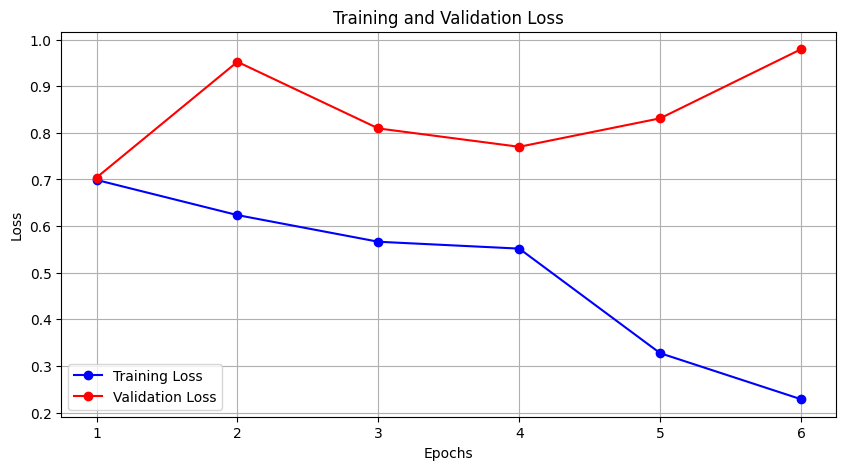

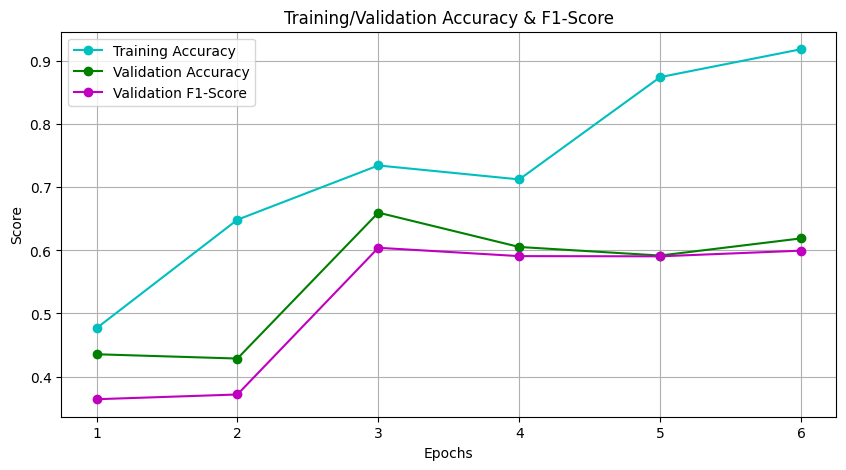

In [17]:
for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
        model.train()
        total_train_loss = 0
        epoch_preds = []
        epoch_labels = []
        
        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = loss_fn(logits, labels)
            total_train_loss += loss.item()
            
            preds = torch.argmax(logits, dim=-1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            progress_bar.set_postfix(loss=loss.item())
        
        progress_bar.close()
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = accuracy_score(epoch_labels, epoch_preds)
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)

        print("Evaluating on development set...")
        val_loss, val_accuracy, val_f1 = evaluate(model, dev_loader, device, loss_fn)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)
        
        print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}. Saving model...")
            best_val_accuracy = val_accuracy
            patience_counter = 0
            
            CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
            model.save_pretrained(CHECKPOINT_PATH)
            preprocessor.tokenizer.save_pretrained(CHECKPOINT_PATH)
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epoch(s).")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Stopping early after {patience_counter} epochs with no improvement.")
            break
        
end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")
    
# Generate and save plots
plot_metrics(history, save_dir=CHECKPOINT_PATH)